In [ ]:
update.packages(ask = F)

Warning message:
“dependency ‘Matrix’ is not available”
also installing the dependencies ‘elliptic’, ‘contfrac’, ‘cowplot’, ‘Deriv’, ‘modelr’, ‘microbenchmark’, ‘R.oo’, ‘R.methodsS3’, ‘hypergeo’, ‘doBy’, ‘diagram’, ‘writexl’, ‘R.utils’, ‘BH’, ‘lmom’, ‘TLMoments’, ‘reshape’, ‘checkmate’


Warning message in install.packages(update[instlib == l, "Package"], l, contriburl = contriburl, :
“installation of package ‘MatrixModels’ had non-zero exit status”


In [1]:
devtools::install_github("ClairBarnes/rwwa")
suppressMessages(library("rwwa"))

ERROR: Error in loadNamespace(i, c(lib.loc, .libPaths()), versionCheck = vI[[i]]): namespace ‘fastmap’ 1.1.0 is already loaded, but >= 1.1.1 is required


In [5]:
ba = read.csv("data/ba-px_pantanal_modis-80.csv")
fwi = read.csv("data/fwi_pantanal_era5.csv")

In [41]:
df = merge(ba, fwi)
df$dsr <- (0.0272 * (df$fwi ^ 1.71))
df$log_ba <- log(df$ba)

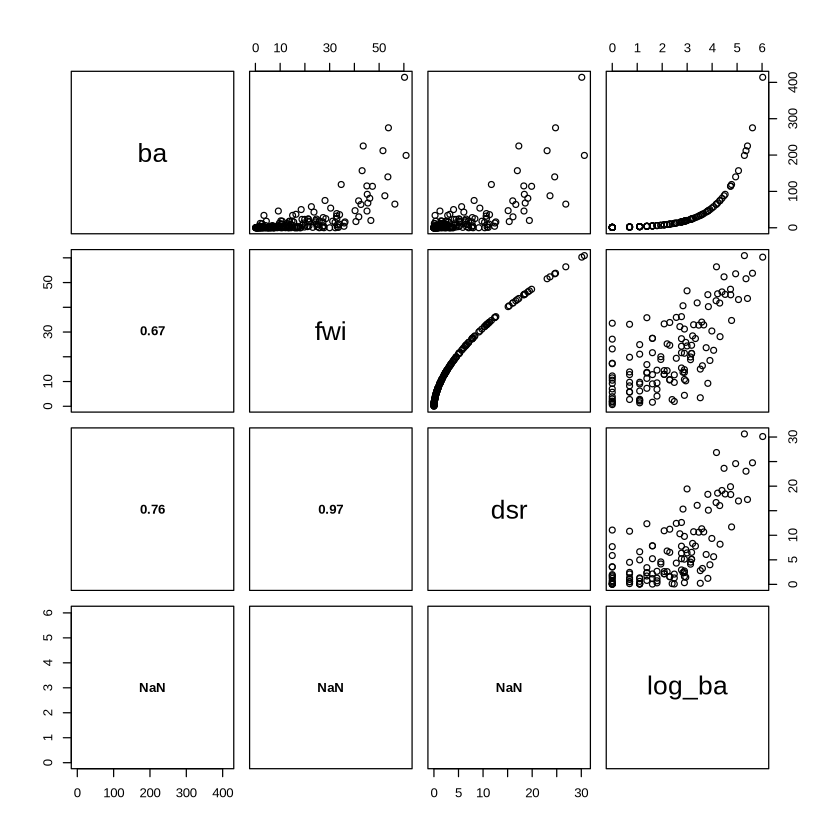

In [42]:
pairs(df[substr(df$time,1,4) == "2024",-1], lower.panel = panel.cor)

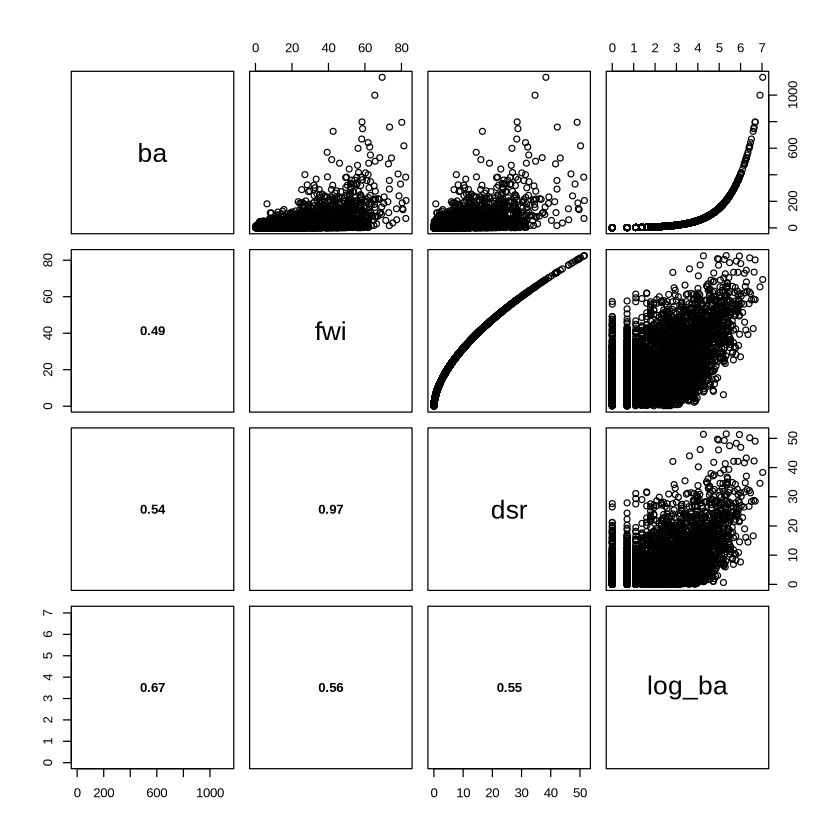

In [49]:
pairs(df[df$ba > 0,-1], lower.panel = panel.cor)

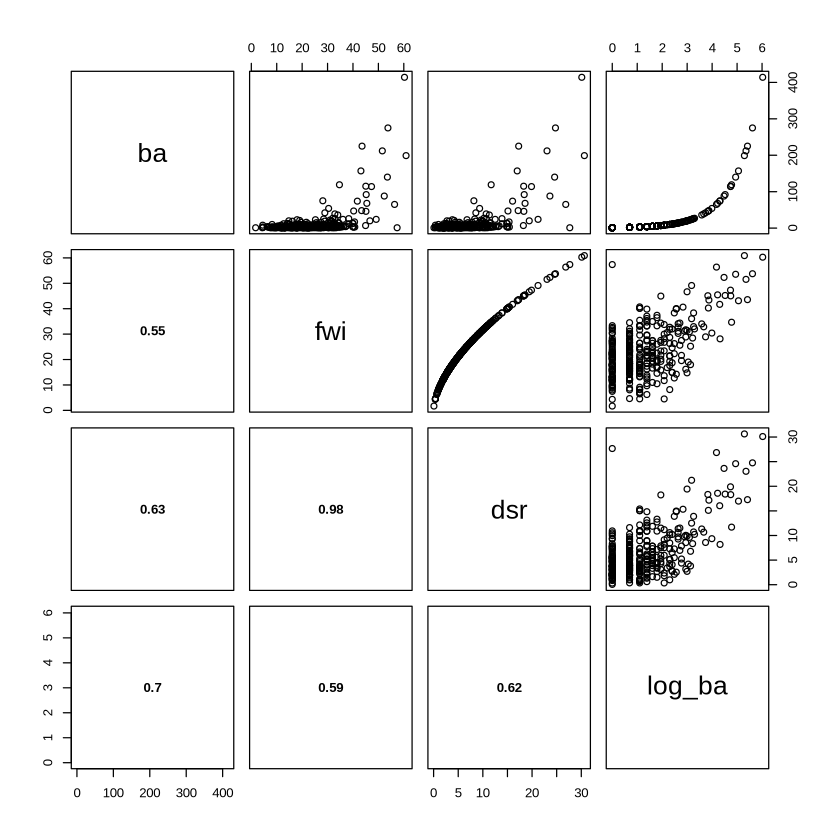

In [50]:
pairs(df[(df$ba > 0) & (substr(df$time,6,7) == "06"),-1], lower.panel = panel.cor)

## June FWI or 15-day FWI?

In [182]:
df$fwi30 = filter(df$fwi, rep(1/30,30), sides = 1)
df$ba30 = filter(df$ba, rep(1/30,30), sides = 1)
df$dsr30 = filter(df$dsr, rep(1/30,30), sides = 1)


df$fwi15 = filter(df$fwi, rep(1/15,15), sides = 1)
df$ba15 = filter(df$ba, rep(1/15,15), sides = 1)

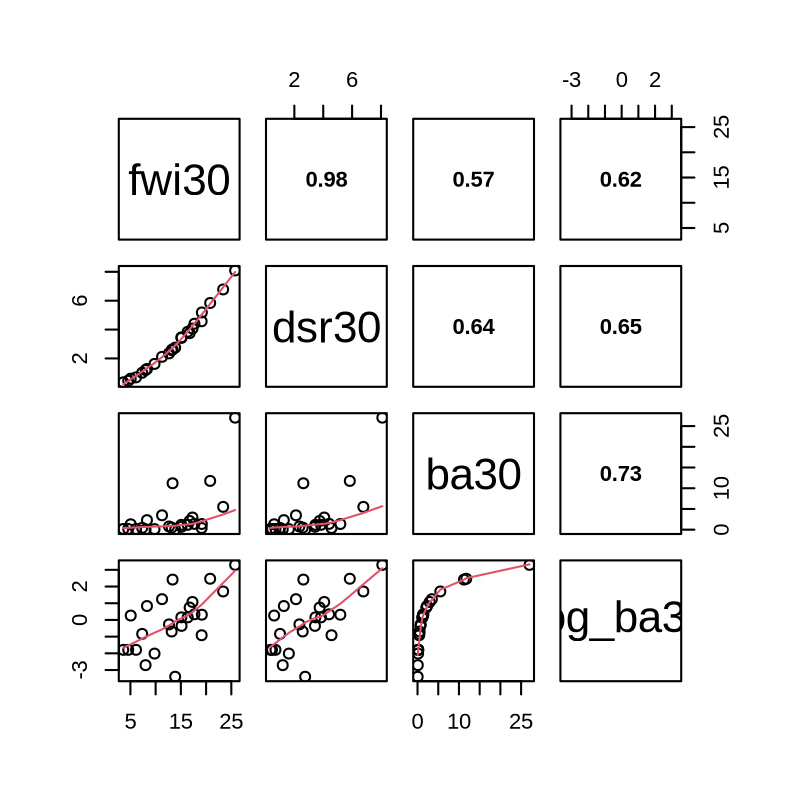

In [183]:
df_june = df[substr(df$time,6,10) == "06-13",c("time", "fwi30", "dsr30", "ba30")]
df_june$log_ba30 = log(df_june$ba30)

pairs(df_june[,-1], upper.panel = panel.cor, lower.panel = panel.smooth)

In [191]:
prep_window(c(1,1))

png("fig/fwi-ba.png", width = 360 * 2, height = 360); {
    prep_window(c(1,2))

    plot(df_june$fwi, df_june$log_ba30, pch = 20, xlab = "June mean FWI", ylab = "log(active fire area in June)", 
         main = paste0("FWI: correlation ", round(cor(df_june$fwi, df_june$log_ba30), 2)))
    lines(lowess(df_june$fwi, df_june$log_ba30), col = "red3")
    abline(line(df_june$fwi, df_june$log_ba30), col = "blue3") 
    legend("topleft", c("Loess smoother", "Linear fit"), col = c("red3", "blue3"), lty = 1)

    plot(df_june$dsr, df_june$log_ba30, pch = 20, xlab = "June mean DSR", ylab = "log(active fire area in June)", 
         main = paste0("DSR: correlation ", round(cor(df_june$dsr, df_june$log_ba30), 2)))
    lines(lowess(df_june$dsr, df_june$log_ba30), col = "red3")
    abline(line(df_june$dsr, df_june$log_ba30), col = "blue3") 
    legend("topleft", c("Loess smoother", "Linear fit"), col = c("red3", "blue3"), lty = 1)
}; dev.off()

png 
  2

In [151]:
df_15d <- df[substr(df$time,6,10) <= "07-15", c("time", "fwi15", "ba15")]
df_15d <- df_15d[!is.na(df_15d$ba15),]

df_15d <- rbind.fill(sapply(2001:2024, function(y) {
    df_y = df_15d[substr(df_15d$time,1,4) == y,]
    df_y[which.max(df_y$fwi),,drop = F]
}, simplify = F))

In [152]:
df_15d$year <- substr(df_15d$time,1,4)
df_june$year <- substr(df_june$time,1,4)
df_15d$log_ba15 <- log(df_15d$ba15)

In [153]:
df_15d <- merge(df_15d, df_june[,c("year", "ba30", "log_ba30")])

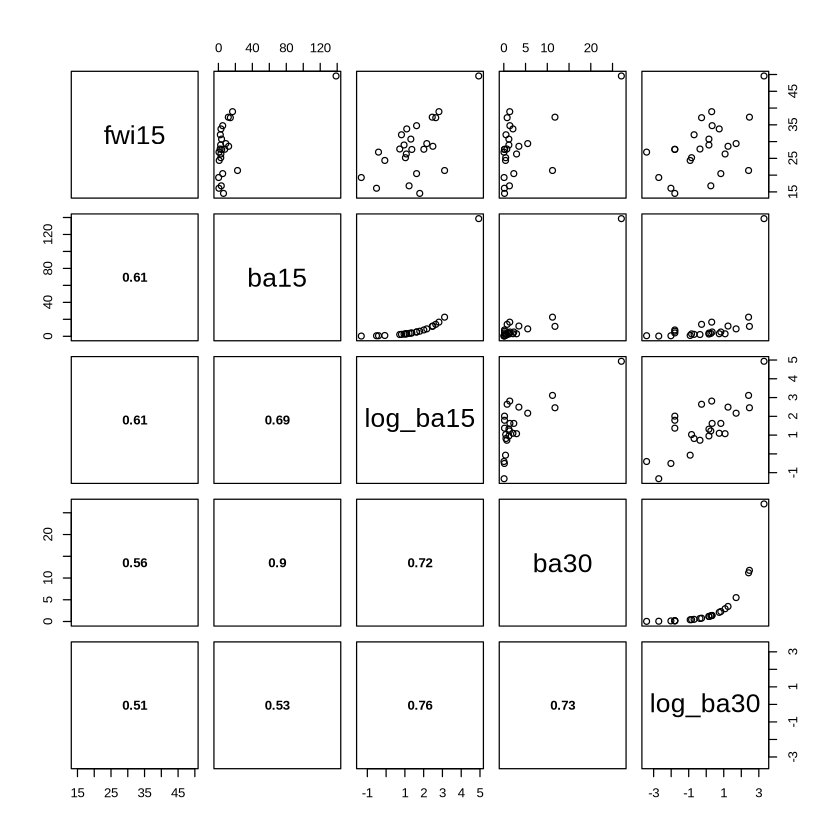

In [155]:
pairs(df_15d[,-(1:2)], lower.panel = panel.cor)

# Trend fitting

In [207]:
fwi <- load_ts("ts_obs/pantanal-fires_fwi-june_era5.dat", col.names = c("year", "fwi"))
dsr <- load_ts("ts_obs/pantanal-fires_dsr-june_era5.dat", col.names = c("year", "dsr"))

nino <- load_ts("ts_obs//pantanal-fires_nino-djf_ersst.dat", col.names = c("year", "nino"))

gmst <- read.table("ts_obs/gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

df <- merge(merge(merge(gmst, nino), fwi), dsr)

df$log_fwi <- log(df$fwi)
df$log_dsr <- log(df$dsr)

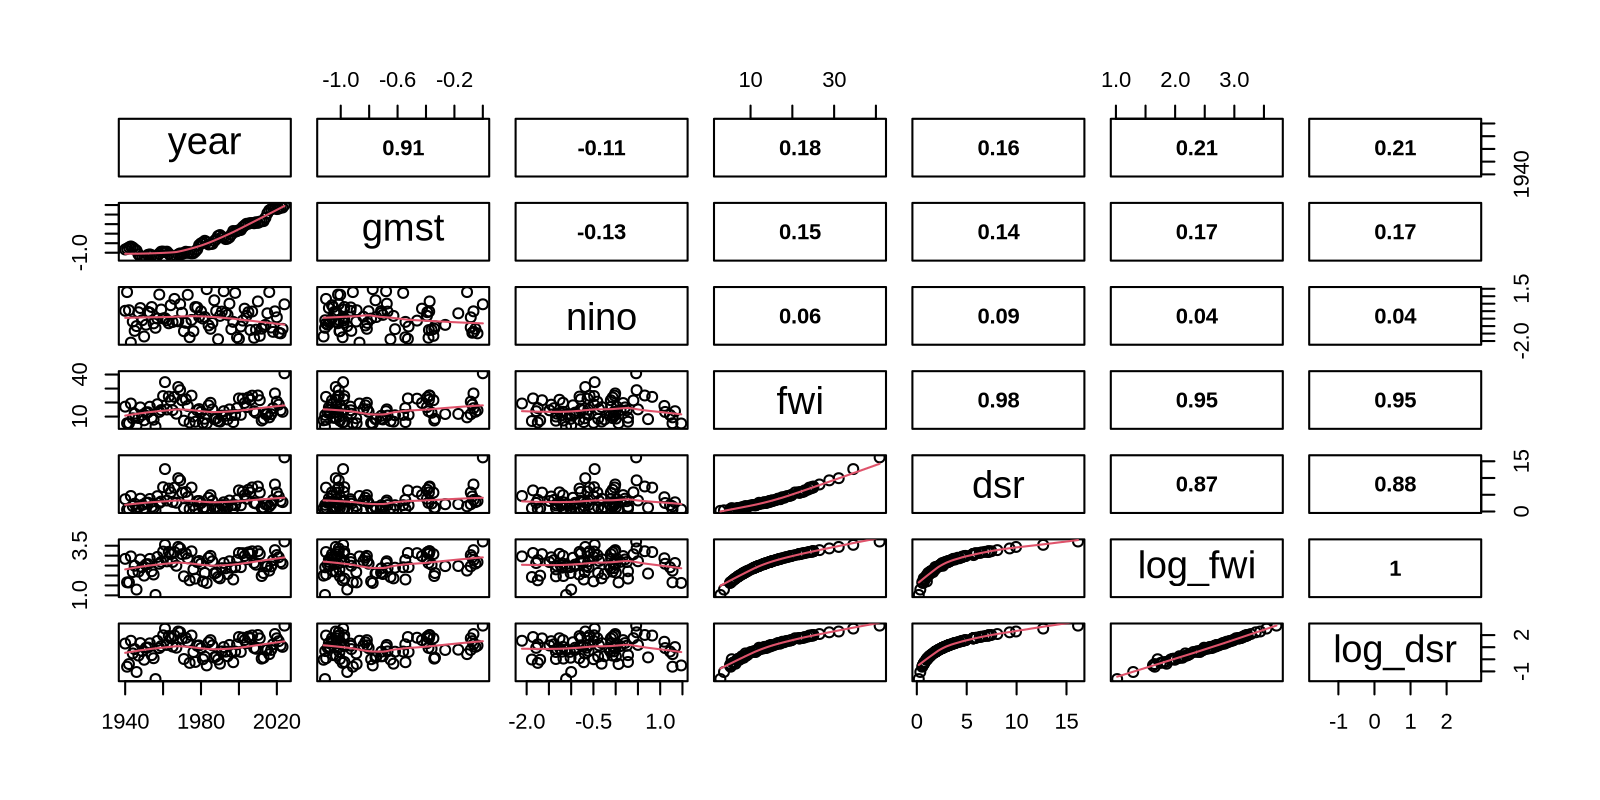

In [224]:
pairs(df, lower.panel = panel.smooth, upper.panel = panel.cor)

In [218]:
mdl_logfwi_gmst <- fit_ns("norm", "shift", df, "log_fwi", c("gmst"))
mdl_logfwi <- fit_ns("norm", "shift", df, "log_fwi", c("gmst", "nino"))
mdl_logdsr_gmst <- fit_ns("norm", "shift", df, "log_dsr", c("gmst"))
mdl_logdsr <- fit_ns("norm", "shift", df, "log_dsr", c("gmst", "nino"))

In [228]:
sapply(list("log FWI (GMST only)" = mdl_logfwi_gmst,
            "log FWI (GMST + Nino)" = mdl_logfwi,
            "log DSR (GMST only)" = mdl_logdsr,
            "log DSR (GMST + Nino)" = mdl_logdsr_gmst), rsquared)

ERROR: Error in eval(expr, envir, enclos): object 'rsquared' not found
